In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\slm\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
class Bandit:
    def __init__(self, num_arms):
        np.random.seed(seed=7)
        self.num_arms = num_arms
        self.lambda_vals = np.random.uniform(0, 1, num_arms)
        self.S = np.zeros(num_arms)
        self.F = np.zeros(num_arms)
    
    def pull_arm(self, arm_index):
        reward = np.random.exponential(self.lambda_vals[arm_index])
        return reward

In [3]:
def thompson_sampling(num_arms, num_episodes):
    bandit = Bandit(num_arms)
    theta = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []

    for t in range(1, num_episodes+1):
        for i in range(num_arms):
            #Theta(i) sampled from Beta(S[i], F[i])
            theta[i] = np.random.beta(bandit.S[i] + 1, bandit.F[i] + 1)

        action = np.argmax(theta)
        reward_probability = bandit.pull_arm(action)

        reward_probability = min(max(reward_probability, 0), 1)
        r_t = np.random.binomial(1, reward_probability)

        if r_t == 1:
            bandit.S[action] += 1
        else:
            bandit.F[action] += 1

        sequence_pulls.append(action)
        reward_round.append(reward_probability)

    return sequence_pulls, reward_round

https://proceedings.mlr.press/v23/agrawal12/agrawal12.pdf

In [4]:
def thompson_sampling_with_budget(num_arms, num_episodes, budget):
    bandit = Bandit(num_arms)
    theta = [0.0] * num_arms
    sequence_pulls = []
    reward_round = []

    for t in range(1, num_episodes+1):
        if t < budget+1:
            # Exploration phase: Randomly select arms without using Thompson Sampling
            action = np.random.randint(0, num_arms)
        else:
            for i in range(num_arms):
                theta[i] = np.random.beta(bandit.S[i] + 1, bandit.F[i] + 1)
            action = np.argmax(theta)
        reward_probability = bandit.pull_arm(action)

        reward_probability = min(max(reward_probability, 0), 1)
        r_t = np.random.binomial(1, reward_probability)

        if r_t == 1:
            bandit.S[action] += 1
        else:
            bandit.F[action] += 1

        sequence_pulls.append(action)
        reward_round.append(reward_probability)

    return sequence_pulls, reward_round

https://arxiv.org/pdf/1505.00146.pdf

In [5]:
def peef(num_arms, num_episodes, epsilon):
    # Array of mean rewards from the previous round
    previous_mean_rewards = np.zeros(num_arms)
    # total pulls available
    totalPullsAvailable = num_episodes
    sequenceArmPulls = np.zeros(totalPullsAvailable)
    # Array of rewards for each round
    reward_round = np.zeros(totalPullsAvailable)
    round = 0
    G = 0
    
    # E.g. Arm 1 is in index 0, so index 0 has arm 1.
    availableArms = np.arange(1,num_arms+1)
    # number of arms pulled 
    numPulled = np.zeros(num_arms)
    numPasses = 0
    roundNum = 1
    # reward array for each arm
    reward_array = np.zeros(num_arms)
    rewards = 0
    numPasses = 0
    # mean rewards vector for this round
    current_meanRewards = np.zeros(num_arms)
    bandit = Bandit(num_arms)
    # The l-split value
    l_split = (epsilon*totalPullsAvailable-1)/(epsilon*totalPullsAvailable-num_arms)
    #print(l_split)
    while len(availableArms)!=0:
        for i in range(num_arms):
            
            # i+1 represents the arm number because we are avoiding an arm value of 0.
            if i+1 in availableArms:
                if totalPullsAvailable>0:
                    action = i
                    #print("Round: ", roundNum, "Arm: ", action, current_meanRewards)
                    roundNum += 1
                    reward = bandit.pull_arm(action)
                    reward_round[round] = reward
                    # Rewards for each arm
                    reward_array[i] += reward
                    # total rewards
                    rewards += reward
                    current_meanRewards[i] = ((current_meanRewards[i]*numPulled[i]) + reward)/(numPulled[i] + 1)
                    sequenceArmPulls[round] = i+1
                    totalPullsAvailable -= 1
                    numPulled[i] += 1
                    round += 1
        numPasses += 1

        availableArms = []
        # How many arms we can pull based on the l_split algorithm
        numToPull = (num_arms) / pow(l_split, numPasses)
         
      # We create this copy arrray for the next while loop which will put -1 on the index 
      # we already inserted into the availableArms so that argmax will not continuously choose
      # the same number.
        copyArrayMean = np.zeros(num_arms)
        for i in range(num_arms):
            copyArrayMean[i] = current_meanRewards[i]
        # ----------------------------------------------------------------------------
        
        while numToPull>0 and num_arms-len(availableArms) is not None:
            curr_max = np.argmax(copyArrayMean)
            if curr_max+1 in availableArms and numToPull!=1:
                # Remove the value that is already in the availableArms array
                copyArrayMean[curr_max] = -1
            if copyArrayMean[np.argmax(copyArrayMean)]!=-1 and totalPullsAvailable>0 and numToPull!=1:   
                availableArms.append(np.argmax(copyArrayMean)+1)
                numToPull -= 1
            elif numToPull==1 and totalPullsAvailable>0:
                availableArms.append(np.argmax(copyArrayMean)+1)
                numToPull -= 1
            else:
                numToPull = 0
        #print(availableArms)
    return sequenceArmPulls, reward_round

In [6]:
def SOAAv(num_arms, num_episodes, factor):
    num_total_pulls = 1
    sequence_pulls = []
    total_reward = 0
    pull_budget = num_episodes
    count_pull = np.zeros(num_arms)
    mean_reward_arm = np.zeros(num_arms)
    arms_available = np.arange(1, num_arms+1)
    total_arm = num_arms
    elimination_factor = factor
    reward_round = np.zeros(num_episodes)  # Initialize reward_round with zeros
    round_num = 0
    bandit = Bandit(num_arms)

    while pull_budget >= 1 and len(arms_available) > 0:
        numPullsInPass = 0
        passAverageRatio = 0

        for i in range(num_arms):
            if (i+1) in arms_available and pull_budget >= 1:
                action = i
                reward = bandit.pull_arm(action)
                reward_round[round_num] = reward
                round_num += 1
                total_reward += reward
                count_pull[action] += 1
                mean_reward_arm[action] = ((mean_reward_arm[action]*count_pull[action]) + reward) / (count_pull[action])
                sequence_pulls.append(action)
                pull_budget -= 1
                num_total_pulls += 1
                passAverageRatio = passAverageRatio + reward
                numPullsInPass += 1

        if numPullsInPass > 0:
            passAverageRatio = passAverageRatio / numPullsInPass
            arms_available = [i+1 for i in range(total_arm) if mean_reward_arm[i] >= (1 + elimination_factor) * passAverageRatio]

    return sequence_pulls, reward_round

In [20]:
class UCB:
    def __init__(self, num_arms):
        np.random.seed(seed=7)
        self.num_arms = num_arms
        self.Q = np.zeros(num_arms)  # Average reward obtained from each action
        self.N = np.zeros(num_arms)  # Number of times each action has been taken
        self.t = 0  # Time step

    def select_action(self):
        if self.t < self.num_arms:
            # Take each action once initially
            action = self.t
        else:
            # UCB formula to select action with the highest UCB value
            ucb_values = self.Q + np.sqrt(2 * np.log(self.t) / (self.N + 1e-6))
            action = np.argmax(ucb_values)

        self.t += 1
        return action

    def update(self, action, reward):
        # Update average reward and number of times the action has been taken
        self.N[action] += 1
        self.Q[action] = ((self.N[action] - 1) * self.Q[action] + reward) / self.N[action]

def UCB_algorithm(num_arms, num_episodes):
    bandit = Bandit(num_arms)
    ucb_agent = UCB(num_arms)
    sequence_pulls = []
    reward_round = []

    for t in range(num_episodes):
        action = ucb_agent.select_action()
        reward = bandit.pull_arm(action)
        ucb_agent.update(action, reward)

        sequence_pulls.append(action)
        reward_round.append(reward)

    return sequence_pulls, reward_round

In [7]:
def singleGraph(num_arms, num_episodes, sequence_pulls, reward_round):
    x = np.arange(1, num_episodes+1)
    y = reward_round
    z = sequence_pulls
    df = pd.DataFrame({'x':x, 'y':y, 'z':z})
    groups = df.groupby('z')
    for name, group in groups:
        plt.plot(group.x, group.y, marker='o', linestyle='', markersize=12, label=name)
        
    # Plotting the Round Number vs. Reward
    plt.xlabel('Round Number')
    plt.ylabel('Reward')
    plt.title('Reward vs. Round Number')
    plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.show()
    
    cumulative_reward = np.cumsum(reward_round)
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.plot(cumulative_reward)
    plt.show()

In [25]:
def multiGraph(num_arms, num_episodes, budget, epsilon, factor):
    # Execute the four methods and store the results
    s1, r1 = thompson_sampling(num_arms, num_episodes)
    s2, r2 = thompson_sampling_with_budget(num_arms, num_episodes, budget)
    s3, r3 = peef(num_arms, num_episodes, epsilon)
    s4, r4 = SOAAv(num_arms, num_episodes, factor)
    s5, r5 = UCB_algorithm(num_arms, num_episodes)

    # Calculate cumulative rewards for each method
    cumulative_reward_1 = np.cumsum(r1)
    cumulative_reward_2 = np.cumsum(r2)
    cumulative_reward_3 = np.cumsum(r3)
    cumulative_reward_4 = np.cumsum(r4)
    cumulative_reward_5 = np.cumsum(r5)

    # Calculate average rewards for each method
    average_reward_1 = np.mean(r1)
    average_reward_2 = np.mean(r2)
    average_reward_3 = np.mean(r3)
    average_reward_4 = np.mean(r4)
    average_reward_5 = np.mean(r5)

    # Plotting cumulative rewards
    plt.plot(cumulative_reward_1, label='Thompson Sampling')
    plt.plot(cumulative_reward_2, label='Thompson Sampling with Budget')
    plt.plot(cumulative_reward_3, label='PEEF')
    plt.plot(cumulative_reward_4, label='SOAAv')
    plt.plot(cumulative_reward_5, label='UCB')
    plt.xlabel('Round')
    plt.ylabel('Cumulative Reward')
    plt.title('Cumulative Rewards Comparison')
    plt.legend()
    plt.show()

    # Plotting average rewards
    average_rewards = [average_reward_1, average_reward_2, average_reward_3, average_reward_4, average_reward_5]
    methods = ['Thompson Sampling', 'Thompson Sampling with Budget', 'PEEF', 'SOAAv', 'UCB']
    plt.bar(methods, average_rewards)
    plt.xlabel('Method')
    plt.ylabel('Average Reward')
    plt.title('Average Rewards Comparison')
    plt.show()
    
    # Plotting average reward over time
    average_reward_over_time_1 = np.cumsum(r1) / np.arange(1, num_episodes+1)
    average_reward_over_time_2 = np.cumsum(r2) / np.arange(1, num_episodes+1)
    average_reward_over_time_3 = np.cumsum(r3) / np.arange(1, num_episodes+1)
    average_reward_over_time_4 = np.cumsum(r4) / np.arange(1, num_episodes+1)
    average_reward_over_time_5 = np.cumsum(r5) / np.arange(1, num_episodes+1)

    plt.plot(average_reward_over_time_1, label='Thompson Sampling')
    plt.plot(average_reward_over_time_2, label='Thompson Sampling with Budget')
    plt.plot(average_reward_over_time_3, label='PEEF')
    plt.plot(average_reward_over_time_4, label='SOAAv')
    plt.plot(average_reward_over_time_5, label='UCB')
    plt.xlabel('Round')
    plt.ylabel('Average Reward')
    plt.title('Average Reward Over Time Comparison')
    plt.legend()
    plt.show()

C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


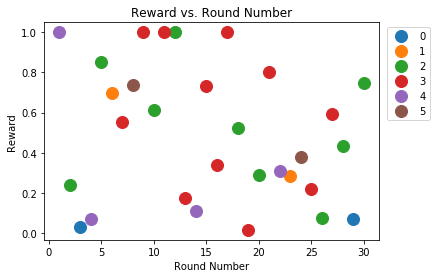

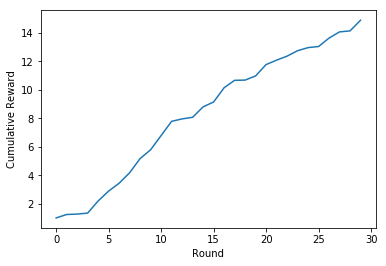

In [10]:
num_arms = 6
epsilon = 0.2
num_episodes = 30
s1, r1 = thompson_sampling(num_arms, num_episodes)
singleGraph(numArms, numRounds, s1, r1)

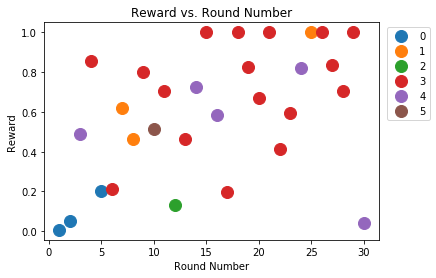

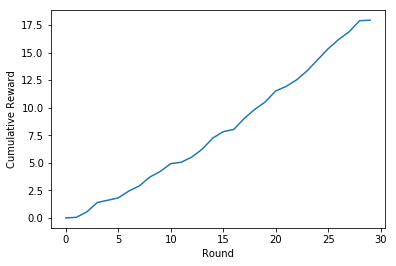

In [17]:
budget = 10
s2, r2 = thompson_sampling_with_budget(num_arms, num_episodes, budget)
singleGraph(numArms, numRounds, s2, r2)

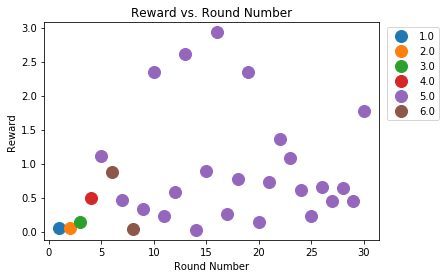

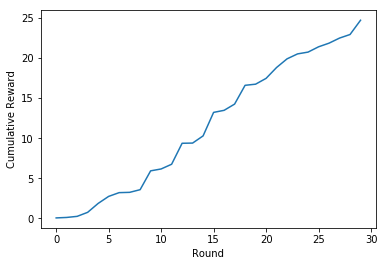

In [12]:
epsilon = 0.25
s3, r3 = peef(num_arms, num_episodes, epsilon)
singleGraph(numArms, numRounds, s3, r3)

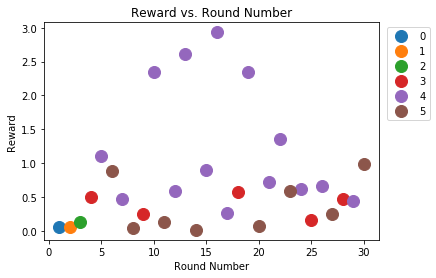

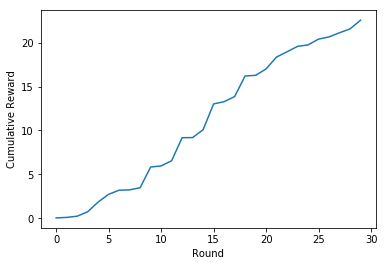

In [13]:
#Only works when factor is very small (<.15)

factor = 0.14
s4, r4 = SOAAv(num_arms, num_episodes, factor)
singleGraph(numArms, numRounds, s4, r4)

C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\slm\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:239: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


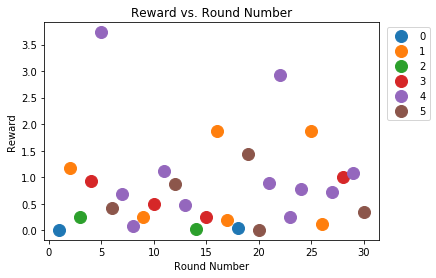

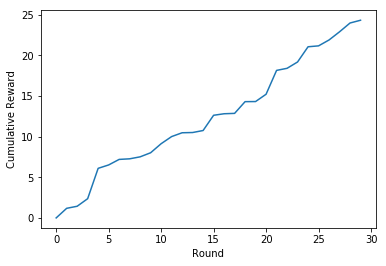

In [22]:
s5, r5 = UCB_algorithm(num_arms, num_episodes)
singleGraph(numArms, numRounds, s5, r5)

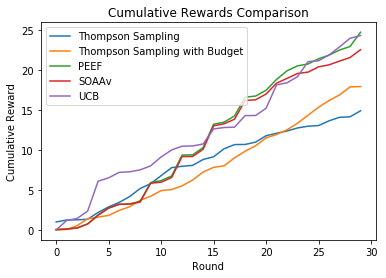

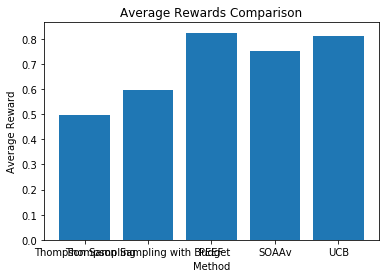

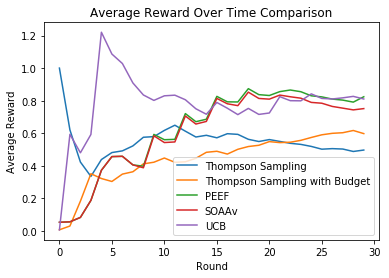

In [26]:
multiGraph(num_arms, num_episodes, budget, epsilon, factor)